In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import nltk

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

lemmatizer = nltk.WordNetLemmatizer()
stemmizer = nltk.PorterStemmer()

In [2]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

,,tweet,"HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000",SUB CATEGORY,COMMENTS,labels,SUB CATEGORY.1,COMMENTS.1,human category (Tarun),SUB CATEGORY.2,COMMENTS.2,NEW CATEGORY,keyword,human - category,human - Sub category,Comment,HUMAN CATGEORY_NEW(ARYA),location,COMMENTS (FROM PARIJAAT),Category,Sub-category
0,2,"@LondOgrad Hello Eugene, we do apologise for t...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,delay,Delay,delay in calls,Huge Queues,customer_service_issues,"London, UK",NaN,{'category': 'Delay',subcategory': 'Delay in bounce back loan'
1,8,@ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...,BAD REPUTATION,NaN,NaN,General,NaN,NaN,NaN,NaN,NaN,Bad_reputation,unhappy,{'category': 'Reputation',subcategory': 'Bad reputation',worst experience from customer – mess,BAD_REPUTATION,"Plymouth, England",NaN,{'category': 'Reputation',subcategory': 'Good reputation'
2,9,"@sharaola Good morning, sorry for your experie...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,customerservice,{'category': 'customer_service issues',subcategory': 'customerservice',General response from bank,General,"Cairo, Egypt",General message from hsbc,{'category': 'Reputation',subcategory': 'Good reputation'
3,11,@Bounce_BackLoan Still not a peep from HSBC,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,NaN,NaN,NaN,Delay_Bounceback_Loan,"delay , no response",{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays',No reply,DELAY_BOUNCEBACK_LOAN,"Enschede, Nederland",DELAY,{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays'
4,15,@djm2481 @mgcmitchell @HSBC_UK Thanks for the ...,Customer Service Response,NaN,customer service reply,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,General,any queries,{'category': 'Reputation',subcategory': 'General Response from Bank (tha...,General response from bank,NaN,United Kingdom,NaN,{'category': 'Reputation',subcategory': 'Good reputation'


In [3]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [4]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [5]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [6]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [7]:
#     text = remove_unicode(text)
#     not (word.startswith('@') | word.startswith('#') | word.startswith('http')) \
#     and len(word) > small_word_lmt \
#     and word not in stop_words \
#     and word.isalpha()
# word not in extra_words
# replace(r"\S*corona\S*" , "covid", regex=True, inplace = True)

In [8]:
replace_word = {"thanks":"thank","covid":"covid", "corona":"covid", "bouncebackloan":"bounce back loan",
                "noresponse":"no response","customers":"customer", "bounceback":"bounce back",
                "backloan":"backloan","on hold":"on_hold", "bbl":"bounce back loan"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [9]:
junk_words = "hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [10]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text
        
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)
    
    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [11]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            word = lemmatizer.lemmatize(word)
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [12]:
lemmatizer.lemmatize("apologise")

'apologise'

In [13]:
stemmizer.stem('apologise')

'apologis'

In [14]:
#adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [15]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [16]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [17]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [18]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [19]:
# def bigram_filter(bigram):
#     tag = nltk.pos_tag(bigram)
#     if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
#         return False
#     if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
#         return False
#     if 'n' in bigram or 't' in bigram:
#         return False
#     if 'PRON' in bigram:
#         return False
#     return True

In [20]:
# # Filter for trigrams with only noun-type structures
# def trigram_filter(trigram):
#     tag = nltk.pos_tag(trigram)
#     if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
#         return False
#     if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
#         return False
#     if 'n' in trigram or 't' in trigram:
#          return False
#     if 'PRON' in trigram:
#         return False
#     return True 

In [21]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
# filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
#                                               bigram_filter(bigram['bigram'])\
#                                               and bigram.pmi > 1, axis = 1)]

# filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
#                                                  trigram_filter(trigram['trigram'])\
#                                                  and trigram.pmi > 1, axis = 1)][:500]


# bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
# trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [22]:
bigrams

['full name',
 'credit card',
 'thank writing',
 'feeder account',
 'still waiting',
 'bounce back',
 'back loan',
 'business account',
 'a feeder',
 'i applied',
 'hello thank',
 'loan i',
 'a bounce']

In [23]:
trigrams

['bounce back loan', 'a feeder account', 'back loan i', 'a bounce back']

In [24]:
replace_word2 = {"bounce back loan":"bounce_back_loan", "full name":"full_name", "credit card":"credit_card",
                "thank writing":"thank_writing","feeder account":"feeder_account", "still waiting":"still_waiting",
                "business account":"business_account"}
for key, value in replace_word2.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [53]:
df[df.tweet.str.contains(r" an ")]["tweet"].tolist()
# df.tweet.str.contains(r" an ").sum()

['tatacrucible an tatacrucible fromthequizmaster contest contestalert padmajaanu adeebashah',
 'tatacrucible an tatacrucible fromthequizmaster contest contestalert',
 'tatacrucible an tatacrucible fromthequizmaster contest contestalert pritinivoriya khemkanidhi emnishant nidhirn chilledsup',
 'tatacrucible fromthequizmaster contest an tatacrucible']

In [26]:
#adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df.tweet = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))

In [27]:
#Aryamaan preprocessing
# data = df.tweet.tolist()

# import math
# from tabulate import tabulate
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# def reduce_func(x):
#     return x**0.5
# data_map = {}
# all_words = set()
# for i, sen in enumerate(data):
#     for word in sen.split(" "):
#         if word in stopwords.words('english'): continue
#         low_word = word.lower()
#         data_map[low_word] = data_map.get(low_word, set())
#         data_map[low_word].add(i)
#         all_words.add(low_word)
# deg = {}
# deg_list = []
# for wrd1 in all_words:
#     tmp_deg = 0
#     for wrd2 in all_words:
#         common = data_map[wrd1] & data_map[wrd2]
#         if len(common) == 0: continue
#         tmp_deg += reduce_func(len(common))
#     deg[wrd1] = tmp_deg
# for wrd in deg:
#     deg_list.append((wrd, deg[wrd]))
# deg_list = sorted(deg_list, key=lambda x : x[1], reverse=True)
# print(tabulate(deg_list, headers=['word', 'deg of importance']))

In [28]:
df_clean = df.tweet
df_clean.shape

(2967,)

In [29]:
df_clean = df_clean.dropna()
df_clean.shape

(2967,)

In [30]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [31]:
from sentence_transformers import SentenceTransformer

In [32]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [33]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [34]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [35]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [36]:
import umap

In [37]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [38]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [39]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [40]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

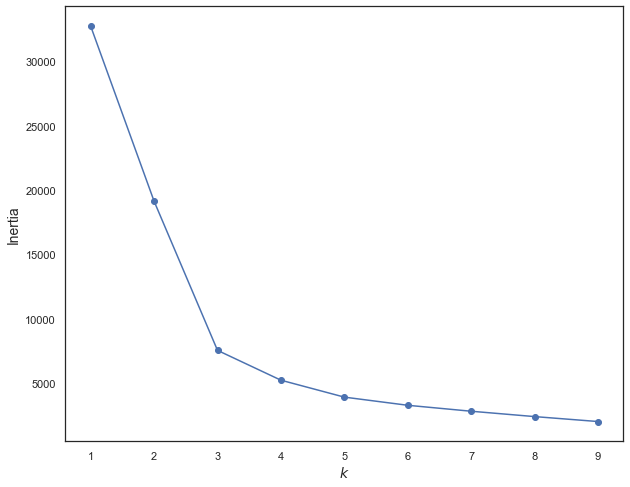

In [43]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [44]:
def cluster_results(Kmeans_clusters=5):
    
    ClusterDict = {}
    global dim_embeddings
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)

    return ClusterDict

In [45]:
clustering_result = cluster_results()

In [46]:
def plot(cluster = clustering_result):    
    
    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = dim_embeddings[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 689, 1: 765, 2: 41, 3: 883, 4: 589}


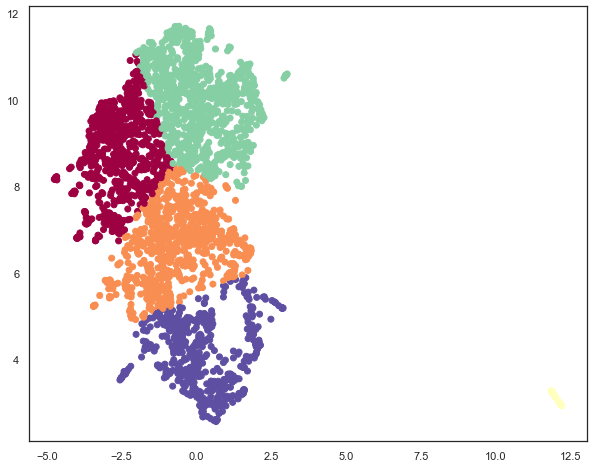

----------UMAP_bert1_norm--------------------
{0: 891, 1: 687, 2: 723, 3: 41, 4: 625}


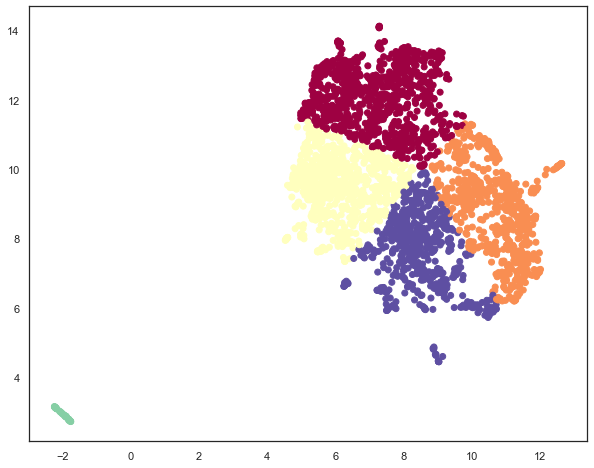

----------UMAP_bert2--------------------
{0: 718, 1: 505, 2: 58, 3: 590, 4: 1096}


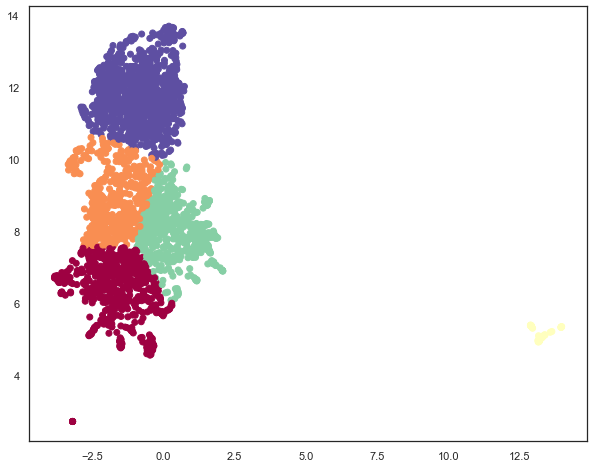

----------UMAP_bert2_norm--------------------
{0: 572, 1: 1132, 2: 61, 3: 699, 4: 503}


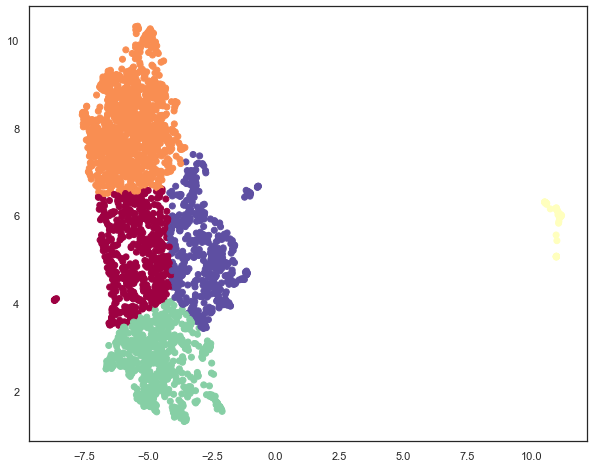

----------PCA_bert1--------------------
{0: 672, 1: 836, 2: 864, 3: 207, 4: 388}


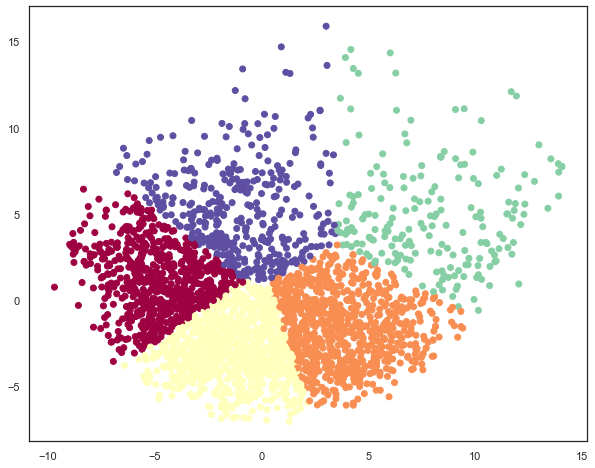

----------PCA_bert1_norm--------------------
{0: 924, 1: 685, 2: 806, 3: 248, 4: 304}


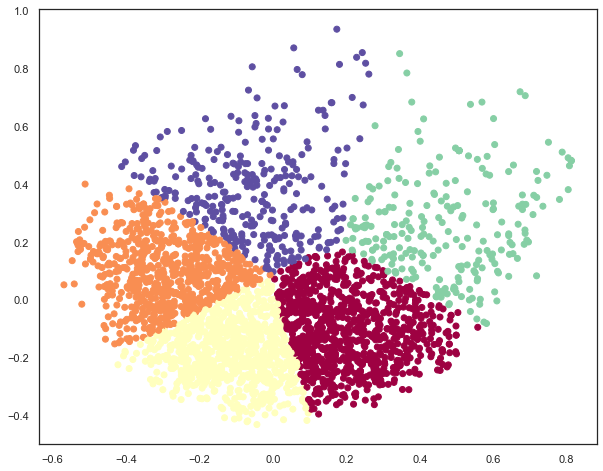

----------PCA_bert2--------------------
{0: 477, 1: 726, 2: 500, 3: 662, 4: 602}


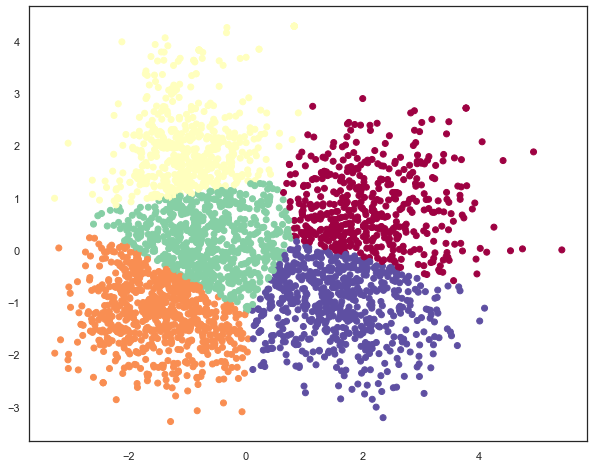

----------PCA_bert2_norm--------------------
{0: 490, 1: 664, 2: 537, 3: 599, 4: 677}


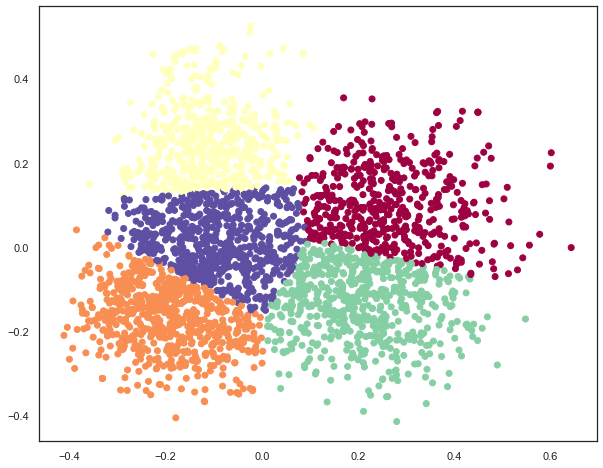

----------tSNE_bert1--------------------
{0: 554, 1: 541, 2: 653, 3: 511, 4: 708}


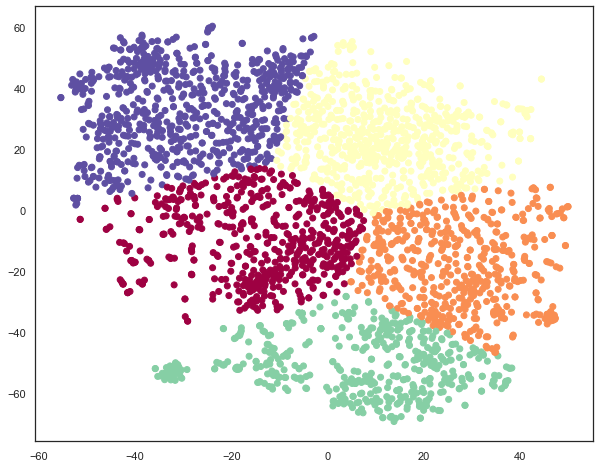

----------tSNE_bert1_norm--------------------
{0: 553, 1: 747, 2: 378, 3: 649, 4: 640}


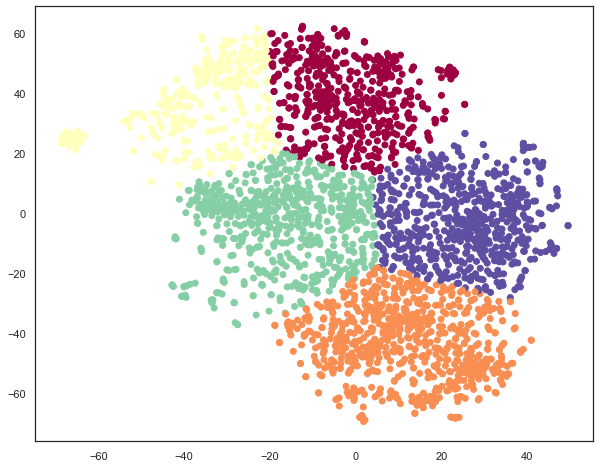

----------tSNE_bert2--------------------
{0: 440, 1: 569, 2: 576, 3: 734, 4: 648}


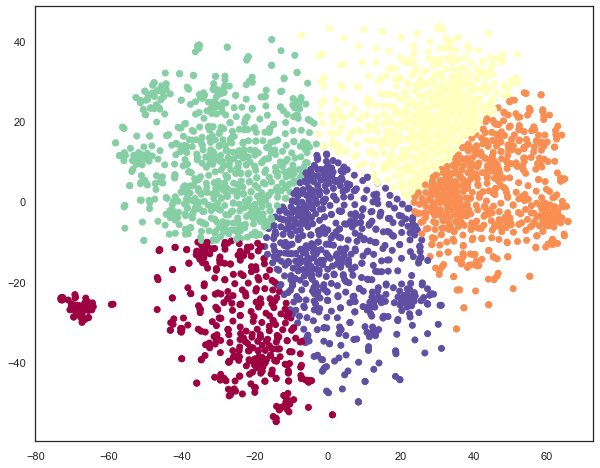

----------tSNE_bert2_norm--------------------
{0: 729, 1: 592, 2: 549, 3: 463, 4: 634}


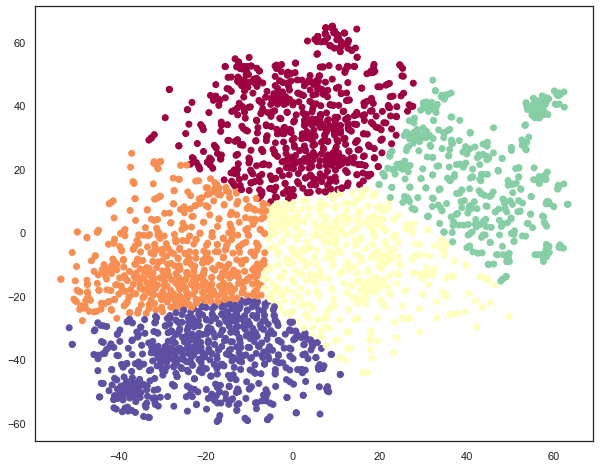

In [47]:
plot()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [49]:
def cluster_words(clustering_result=clustering_result, top_n = 15, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [50]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,28,28,1,162,10
CHURN,8,6,0,21,2
COVID19,16,14,0,18,2
CUSTOMER_SERVICE_ISSUES,62,51,0,96,18
Customer Query,28,80,0,35,25
Customer Service Response,63,148,0,108,334
DELAY,347,129,0,236,4
ESG,0,1,0,4,1
GOOD REPUTATION,15,21,0,27,38


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,week,day,applied,still,account,application,customer,back,thank,business,hour,email,time,money
1,bounce_back_loan,account,thank,hello,please,customer,help,call,application,email,back,number,need,business,money
2,tatacrucible,contestalert,contest,fromthequizmaster,join,an,ranchikuldeep,sanketdhende,chilledsup,smileybharati,tagging,emnishant,booknworm,chocolatyvasu,devanginee
3,bounce_back_loan,customer,nothing,applied,account,thank,day,worst,hello,business,call,please,application,help,time
4,thank,hello,please,link,team,send,help,full_name,kindly,call,detail,dm,sorry,assist,thank_writing


====================================UMAP_bert1_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,164,10,27,1,27
CHURN,20,2,8,0,7
COVID19,16,3,9,0,22
CUSTOMER_SERVICE_ISSUES,98,25,70,0,34
Customer Query,38,34,35,0,61
Customer Service Response,94,446,64,0,49
DELAY,251,10,343,0,112
ESG,4,1,1,0,0
GOOD REPUTATION,28,47,15,0,11


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,nothing,customer,applied,account,day,business,thank,application,call,hello,time,help,still,worst
1,thank,hello,please,team,link,help,send,call,full_name,number,sorry,detail,kindly,assist,dm
2,bounce_back_loan,week,day,applied,account,still,application,customer,thank,back,email,business,waiting,call,hour
3,tatacrucible,contestalert,contest,fromthequizmaster,join,an,ranchikuldeep,sanketdhende,chilledsup,smileybharati,tagging,emnishant,booknworm,chocolatyvasu,devanginee
4,bounce_back_loan,account,hello,thank,customer,feeder_account,covid,application,business,back,email,money,applied,please,same


====================================UMAP_bert2=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,12,82,1,54,80
CHURN,2,11,0,7,17
COVID19,1,4,1,42,2
CUSTOMER_SERVICE_ISSUES,22,139,0,24,42
Customer Query,23,44,0,58,43
Customer Service Response,530,48,0,50,25
DELAY,7,70,0,21,618
ESG,2,1,0,3,0
GOOD REPUTATION,30,30,0,27,14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,thank,hello,please,team,link,full_name,send,help,call,sorry,kindly,thank_writing,assist,dm,detail
1,customer,call,account,thank,bounce_back_loan,day,hour,service,hello,worst,time,barclays,still,back,phone
2,tatacrucible,fromthequizmaster,contestalert,contest,join,an,emnishant,mysterioussu,ranchikuldeep,sanketdhende,chilledsup,shanghai,smileybharati,tagging,booknworm
3,account,thank,money,covid,new,credit_card,amp,hello,hsbcin,payment,please,help,sony,when,card
4,bounce_back_loan,applied,week,feeder_account,application,day,account,email,business,customer,nothing,still,waiting,back,time


====================================UMAP_bert2_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,57,85,1,14,72
CHURN,7,18,0,2,10
COVID19,4,1,1,3,41
CUSTOMER_SERVICE_ISSUES,117,48,0,17,45
Customer Query,79,43,0,35,11
Customer Service Response,108,24,0,515,6
DELAY,72,623,0,5,16
ESG,0,0,0,0,6
GOOD REPUTATION,16,17,0,27,41


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,account,thank,hello,call,help,day,please,money,time,application,customer,hour,back,still,need
1,bounce_back_loan,applied,week,day,application,account,email,feeder_account,business,customer,nothing,still,waiting,back,time
2,tatacrucible,fromthequizmaster,contestalert,contest,join,an,emnishant,mysterioussu,ranchikuldeep,sanketdhende,chilledsup,shanghai,smileybharati,tagging,booknworm
3,thank,hello,please,team,link,send,detail,help,full_name,call,dm,thank_writing,kindly,message,assist
4,customer,thank,barclays,hsbcin,covid,gold,worst,money,amp,service,business,year,sony,bounce_back_loan,new


====================================PCA_bert1=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,90,12,43,11,73
CHURN,12,2,11,2,10
COVID19,19,12,12,0,7
CUSTOMER_SERVICE_ISSUES,80,25,73,14,35
Customer Query,29,58,58,10,13
Customer Service Response,40,400,126,30,57
DELAY,278,55,315,5,63
ESG,4,1,1,0,0
GOOD REPUTATION,21,33,25,18,4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,week,nothing,customer,account,applied,business,day,worst,email,call,time,application,still,year
1,thank,hello,please,bounce_back_loan,team,link,help,call,send,kindly,tatacrucible,assist,account,dm,full_name
2,bounce_back_loan,account,thank,email,week,application,day,applied,hello,customer,please,back,business,call,help
3,thank,tatacrucible,hsbcin,much,bounce_back_loan,help,please,welcome,hello,stay,dm,know,link,safe,sent
4,bounce_back_loan,nothing,customer,still,hello,thank,worst,please,service,dont,day,applied,being,time,account


====================================PCA_bert1_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,16,101,41,9,62
CHURN,2,9,14,2,10
COVID19,16,19,10,0,5
CUSTOMER_SERVICE_ISSUES,34,73,74,13,33
Customer Query,64,31,51,12,10
Customer Service Response,423,54,97,47,32
DELAY,73,260,325,7,51
ESG,1,4,1,0,0
GOOD REPUTATION,33,21,22,21,4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,thank,hello,bounce_back_loan,please,team,link,call,help,tatacrucible,account,send,back,kindly,assist,number
1,bounce_back_loan,week,customer,nothing,account,applied,business,day,call,email,application,time,worst,still,thank
2,bounce_back_loan,account,week,email,application,day,applied,thank,customer,hello,business,please,back,time,call
3,thank,hello,tatacrucible,please,hsbcin,help,much,bounce_back_loan,day,dm,know,welcome,sent,zar,barclays
4,bounce_back_loan,nothing,still,customer,worst,service,day,please,dont,hello,market,gold,gld,say,awful


====================================PCA_bert2=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,40,32,39,87,31
CHURN,7,2,6,11,11
COVID19,1,1,42,6,0
CUSTOMER_SERVICE_ISSUES,8,86,8,77,48
Customer Query,21,50,6,73,18
Customer Service Response,5,472,15,141,20
DELAY,236,31,11,68,370
ESG,0,0,5,1,0
GOOD REPUTATION,6,16,21,29,29


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,account,week,business,feeder_account,customer,applied,day,still,application,money,rishisunak,loan,waiting,still_waiting
1,hello,thank,please,call,team,send,help,link,assist,number,kindly,message,sorry,phone,detail
2,tatacrucible,fromthequizmaster,contest,contestalert,covid,thank,sony,gold,amp,citi,nigeria,join,asia,market,hongkong
3,account,thank,customer,please,hello,money,bounce_back_loan,help,day,time,transfer,business,being,service,still
4,bounce_back_loan,application,applied,email,day,week,customer,business,nothing,account,waiting,call,feeder_account,back,still


====================================PCA_bert2_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,41,29,44,30,85
CHURN,8,2,6,9,12
COVID19,1,1,43,0,5
CUSTOMER_SERVICE_ISSUES,9,79,9,47,83
Customer Query,20,50,7,21,70
Customer Service Response,5,434,19,19,176
DELAY,242,26,12,368,68
ESG,0,0,6,0,0
GOOD REPUTATION,7,11,23,27,33


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,week,account,business,feeder_account,applied,day,customer,still,rishisunak,money,application,waiting,loan,still_waiting
1,hello,thank,please,call,team,help,link,send,number,kindly,assist,message,detail,sorry,thank_writing
2,tatacrucible,fromthequizmaster,contest,contestalert,covid,thank,sony,gold,amp,citi,nigeria,join,market,asia,new
3,bounce_back_loan,application,email,applied,day,week,customer,account,business,nothing,feeder_account,call,still,waiting,back
4,thank,account,hello,customer,please,help,time,money,bounce_back_loan,back,day,service,still,which,hsbcin


====================================tSNE_bert1=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,43,9,28,12,137
CHURN,5,2,7,3,20
COVID19,20,11,2,6,11
CUSTOMER_SERVICE_ISSUES,27,39,66,12,83
Customer Query,33,57,33,18,27
Customer Service Response,76,255,63,206,53
DELAY,135,44,327,7,203
ESG,1,0,0,1,4
GOOD REPUTATION,8,13,13,41,26


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bounce_back_loan,account,thank,hello,customer,help,still,call,time,application,please,money,covid,back,feeder_account
1,hello,thank,bounce_back_loan,please,account,link,email,call,send,team,number,phone,need,help,more
2,bounce_back_loan,week,day,account,applied,application,customer,still,thank,back,last,business,hour,email,time
3,thank,tatacrucible,hello,fromthequizmaster,contestalert,please,contest,team,help,sorry,kindly,dm,link,back,detail
4,bounce_back_loan,nothing,customer,applied,worst,account,day,business,email,still,thank,year,service,application,call


====================================tSNE_bert1_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,8,139,12,41,29
CHURN,2,19,1,5,10
COVID19,3,10,11,23,3
CUSTOMER_SERVICE_ISSUES,19,89,15,42,62
Customer Query,39,31,11,58,29
Customer Service Response,379,56,69,67,82
DELAY,12,227,6,166,305
ESG,1,4,0,1,0
GOOD REPUTATION,27,23,26,11,14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,hello,thank,please,team,link,call,help,send,number,detail,full_name,sorry,kindly,assist,email
1,bounce_back_loan,nothing,customer,applied,day,account,business,week,email,worst,still,application,call,thank,service
2,tatacrucible,fromthequizmaster,thank,contestalert,contest,asia,hello,help,hsbcin,much,amp,join,citi,happy,safe
3,bounce_back_loan,account,thank,hello,customer,email,application,money,feeder_account,help,still,applied,please,sony,business
4,bounce_back_loan,week,day,account,applied,application,customer,email,back,thank,waiting,time,business,still,last


====================================tSNE_bert2=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,16,52,42,24,95
CHURN,2,8,9,3,15
COVID19,42,1,1,2,4
CUSTOMER_SERVICE_ISSUES,7,22,23,37,138
Customer Query,9,26,19,43,71
Customer Service Response,72,5,27,484,65
DELAY,5,276,352,8,75
ESG,3,0,0,2,1
GOOD REPUTATION,17,9,7,32,36


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,tatacrucible,fromthequizmaster,contest,contestalert,covid,thank,gold,hello,more,call,assist,sony,refer,information,amp
1,bounce_back_loan,feeder_account,account,email,week,applied,day,still,customer,signed,back,nothing,application,waiting,time
2,bounce_back_loan,applied,application,day,week,business,customer,waiting,account,nothing,rishisunak,still,loan,received,email
3,thank,hello,please,team,send,link,help,kindly,sorry,full_name,dm,back,detail,number,call
4,account,customer,bounce_back_loan,call,thank,hello,credit_card,please,money,hour,need,hsbcin,phone,when,day


====================================tSNE_bert2_norm=============================================


cluster,0,1,2,3,4
labels,,,,,
BAD REPUTATION,17,50,92,20,50
CHURN,2,10,16,0,9
COVID19,2,2,3,42,1
CUSTOMER_SERVICE_ISSUES,32,72,102,8,13
Customer Query,40,33,53,13,29
Customer Service Response,547,25,54,19,8
DELAY,11,291,77,3,334
ESG,0,0,1,5,0
GOOD REPUTATION,19,11,31,32,8


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,hello,thank,please,team,full_name,link,send,assist,call,help,thank_writing,kindly,detail,sorry,dm
1,bounce_back_loan,applied,email,application,day,nothing,account,week,still,call,back,received,signed,told,phone
2,account,customer,bounce_back_loan,thank,business,call,barclays,service,hour,day,hello,money,credit_card,help,worst
3,tatacrucible,fromthequizmaster,thank,contest,contestalert,covid,gold,sony,citi,nigeria,market,hsbcin,asia,branch,amp
4,bounce_back_loan,feeder_account,week,account,applied,business,customer,waiting,day,application,still,feeder,rishisunak,need,please
